<img src = "https://drive.google.com/uc?export=view&id=1kl2OFnF2FADAAKjgZUFPo8dsBQUSIJM7" alt = "Encabezado MLDS" width = "100%">  </img>

# **_Transfer Learning_ y _Fine Tuning_ para Clasificación de Objetos en Imágenes**
----

En este Notebook daremos una introducción a las técnicas de **_Transfer Learning_** y **_Fine Tuning_**. Se tratan de técnicas comúnmente usadas para entrenar redes neuronales de forma más rápida y con resultados más precisos, basándose en modelos previamente construidos y entrenados en tareas similares. En este notebook estudiaremos un ejemplo práctico utilizando redes neuronales convolucionales preentrenadas para un uso de propósito general. Más específicamente veremos:
- Modelos pre-entrenados en _Tensorflow_ con _ImageNet_
- _Transfer Learning_
  - Definición de los modelos
  - Preprocesamiento
  - Entrenamiento
  - Evaluación
- _Fine Tuning_
  - _Warming Up_
  - Entrenamiento
- Evaluación de los modelos

Primero, como siempre, importamos los paquetes necesarios:

In [ ]:
# Seleccionamos la versión más reciente de Tensorflow 2.0
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, random

plt.style.use("ggplot")
# Seleccionamos una semilla para los RNG
tf.random.set_seed(0)
np.random.seed(0)

En este caso utilizaremos un dataset que contiene imágenes de rostros. Algunos de estos rostros son falsos; han sido creados usando herramientas profesionales de edición de imágenes (por expertos humanos). Veamos el conjunto de datos:

In [ ]:
!git clone https://github.com/mindlab-unal/mlds5-datasets-unit3-TransferLearning.git

Cloning into 'mlds5-datasets-unit3-TransferLearning'...
remote: Enumerating objects: 2055, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 2055 (delta 1), reused 9 (delta 1), pack-reused 2046
Receiving objects: 100% (2055/2055), 215.17 MiB | 22.74 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (2042/2042), done.


In [ ]:
base_path = '/content/mlds5-datasets-unit3-TransferLearning/real_and_fake_face'

Comenzaremos cargando el dataset :

In [ ]:
# Cargamos el conjunto de datos
all_images = []
labels = []
for i,val in enumerate([base_path+"/fake/", base_path+"/real/"]):
    temp_path = val
    for im_path in os.listdir(temp_path):
        all_images.append(np.array(tf.keras.preprocessing.image.load_img(temp_path+im_path,
                                                                         target_size=(224, 224, 3))))
        labels.append(i)
X = np.array(all_images)
y = np.array(labels)

In [ ]:
# Miramos el tamaño en cada dimensión del dataset:
X.shape

(2041, 224, 224, 3)

Es decir, tenemos 2041 imágenes RGB de 224 por 224 pixeles. Hacemos una partición de entrenamiento y prueba:

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=15)

Codificamos las etiquetas usando *one-hot representation*, una variable binaria por cada posible clase de salida :

In [ ]:
Y_train = tf.keras.utils.to_categorical(y_train)
Y_val = tf.keras.utils.to_categorical(y_val)

Veamos algunos ejemplos de imágenes del dataset. La etiqueta 0 representa las imágenes falsas, y 1 las verdaderas:

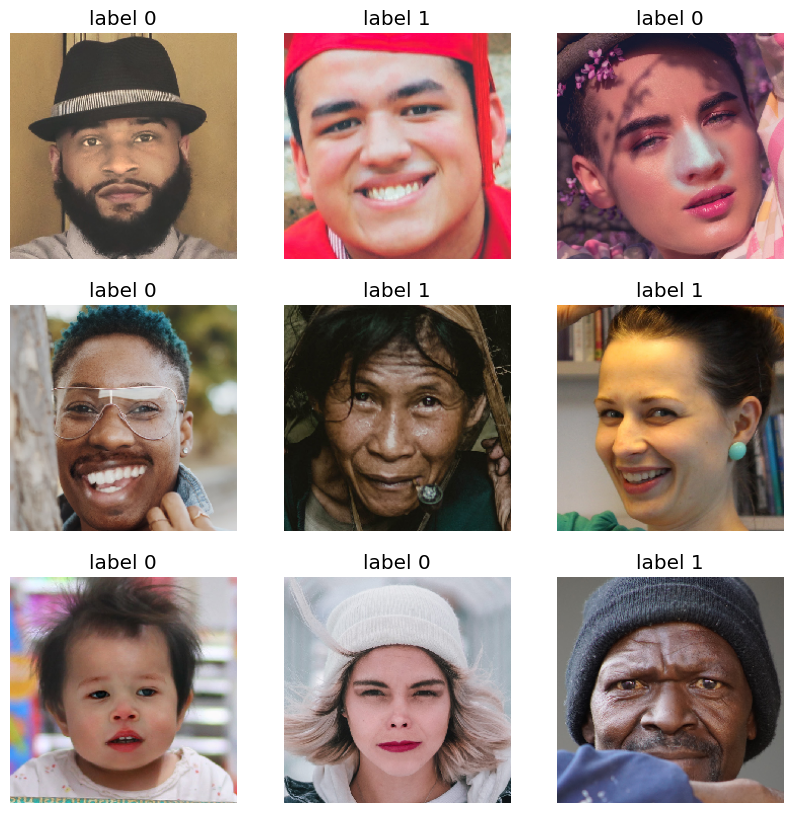

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    # Seleccionamos una imagen al azar
    idx = np.random.randint(X_train.shape[0])
    ax[i//3, i%3].imshow(X_train[idx]); ax[i//3, i%3].axis("off")
    ax[i//3, i%3].set_title(f"label {y_train[idx]}")

# **ImageNet**
----
La popularidad del **_Transfer Learning_** se dio fundamentalmente a partir de los [resultados](https://paperswithcode.com/sota/image-classification-on-imagenet) del [proyecto ImageNet](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi8uajxj-79AhWDbTABHeRGDXQQFnoECAoQAQ&url=https%3A%2F%2Fwww.image-net.org%2Fchallenges%2FLSVRC%2F&usg=AOvVaw1dIu39wO1j2Vb7VlfjJ9tc), el cual provee una gran base de datos visual diseñada para la tarea de reconocimiento de objetos. - Contiene más de **14 millones de imágenes** que fueron manualmente etiquetadas en más de 20.000 categorías diferentes.


<center><img src = "https://drive.google.com/uc?export=view&id=1kAx9nUlvvgHIz3NcA2cI_TcS5uQD9nuX" alt = "ImageNet Set" width = "60%">  </img></center>



El proyecto **ImageNet** tiene una competencia anual conocida como *the ImageNet Large Scale Visual Recognition Challenge* (ILSVRC), donde distintos métodos compiten para clasificar y detectar objetos de forma correcta.

- A partir del **año 2012**, los métodos de *deep learning* comenzaron a ganar atención cuando una arquitectura de red convolucional conocida como **_AlexNet_** ganó la competencia, superando al ganador del año anterior con un 10% menos de error en la clasificación. Adicionalmente, en el **año 2015** una arquitectura de red neuronal (**_ResNet_**) demostró tener un error menor en comparación con un ser humano, mostrando así, que las máquinas son mejores que las personas en este tipo de tarea.

<center><img src = "https://drive.google.com/uc?export=view&id=1Lke35whYl9sazWlTErLUAe3YJaKT_ZsT" alt = "2012 ImageNet Competition" width = "70%">  </img></center>

Una de las principales ventajas de estos resultados es que **los pesos de las redes son liberado**s para ser utilizados por cualquier persona. Por ello, el *Transfer Learning* se volvió una práctica típica en la experimentación de *deep learning*.

- En general, la idea consiste en utilizar un modelo robusto (que fue entrenado con millones de datos) y aplicarlo a una tarea específica tal y como se ilustra en la siguiente figura :

<center><img src = "https://drive.google.com/uc?export=view&id=1wymIS_mzuoc393UJGEHiIDYem2je-CsO" alt = "Transfer Learning" width = "70%">  </img></center>


# **1. Modelos Pre-entrenados**
----

_TensorFlow_ nos permite utilizar varias arquitecturas pre-entrenadas con ImageNet; podemos encontrarlas en [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications). Algunas de las más famosas son:

* VGG16
* ResNet152
* InceptionV3
* MobileNetV2

Si bien todas estas aplicaciones se construyen a partir de bloques convolucionales, cada una tiene una arquitectura particular, lo que influye directamente en aspectos como :
- **El tamaño del modelo**, es decir el número de parámetros entrenables,
- **La velocidad de cómputo** y su desempeño para distintas tareas específicas.

La siguiente tabla nos muestra el tamaño de las aplicaciones mencionadas antes, el número de parámetros, y el desempeño (medido en exactitud) en la tarea de clasificación de ImageNet
- La tabla completa se puede consultar en [Keras Applications](https://keras.io/applications/) :

| Aplicación  | Tamaño | Parámetros | Exactitud |
| ----------- | ----------- | ----------- | ----------- |
| VGG16       | 528 MB      | 138.4M      | 90.1%       |
| ResNet152   | 232 MB      |  60.4M      | 93.1%       |
| InceptionV3 |  92 MB      |  23.9M      | 93.7%       |
| MobileNetV2 |  14 MB      |   3.5M      | 90.1%       |

Si bien cada aplicación tiene un desempeño específico en la tarea de clasificación de imágenes de ImageNet, no se puede concluir, por ejemplo, que **ResNet152** va a tener un mejor desempeño que **MobileNetV2** en cualquier tarea de clasificación de imágenes.
- En general, cuando se busca usar un modelo preentrenado, se debe seleccionar una arquitectura base apropiada para cada problema en particular, buscando un equilibrio entre el costo computacional, tamaño y el desempeño :

<center><img src = "https://drive.google.com/uc?export=view&id=1fKuH0HIgCrJzJlQhHbmhnm1bJlb-5wXO" alt = "Top Accuracy" width = "50%">  </img></center>

Veamos un ejemplo de cómo cargar a nuestro entorno una aplicación, específicamente VGG16.

Lo que vamos a hacer es definir un modelo usando la función `tf.keras.applications.VGG16`. Cada modelo se define usando su respectiva función, que recibe una serie de argumentos:

*    `include_top`: `True` o `False`, sirve para incluir la capa totalmente conectada en la parte superior del modelo, como última capa de la red. Como estos modelos se han entrenado con ImageNet, esta capa, si se incluye, tiene tamaño 1000, por las 1000 clases de ImageNet. Por tanto, si se quiere usar el modelo para una tarea diferente con _Transfer Learning_ o _Fine Tuning_, se debe asignar `False` a este parámetro. Por defecto es `True`.
*    `weights`: `None` para una inicialización aleatoria, o `imagenet` para cargar los pesos del preentrenamiento en ImageNet, o la ruta al archivo de pesos que se va a cargar. Por defecto es `imagenet`.
*    `input_tensor`: puede ser la salida de un `layers.Input()` para utilizar como entrada de imagen para el modelo. Por defecto es `None`.
*    `input_shape`: Tupla de forma opcional, sólo debe especificarse si `include_top` es `False` (de lo contrario, la forma de entrada debe ser `(224, 224, 3)` para VGG16. Debe tener exactamente 3 canales de entrada, y la anchura y la altura no deben ser inferiores a 75.
*    `pooling`: Modo de agrupación opcional para la extracción de características cuando `include_top` es `False`.
*    `classes`: número de clases en las que clasificar las imágenes, sólo debe especificarse si `include_top` es `True`, y si no se especifica ningún argumento de pesos. Por defecto es `1000`.
*    `classifier_activation`: La función de activación a utilizar en la capa de salida. Se ignora a menos que `include_top=True`. Por defecto es `softmax`.


In [ ]:
# Cargamos una red VGG16
model = tf.keras.applications.VGG16(weights='imagenet',
                                    include_top=True,
                                    input_shape=(224, 224, 3))
model.summary()

553467096/553467096 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

En el modelo pusimos `include_top=True`. Entonces veamos un ejemplo de la clasificación de cuatro imágenes en las categorías originales de ImageNet :

In [ ]:
# Descargamos algunas imágenes de ejemplo
!wget -O koala.jpg https://upload.wikimedia.org/wikipedia/commons/4/49/Koala_climbing_tree.jpg
!wget -O wolf.jpg https://upload.wikimedia.org/wikipedia/commons/d/d7/Wolf_Kolm%C3%A5rden.jpg
!wget -O tiger.jpg https://steemit-production-imageproxy-upload.s3.amazonaws.com/DQmenD8j2rha9SkqpB1gQDrkuE9FmjBTwxb4eGbmHQ81aGM
!wget -O cat.jpg https://as.com/epik/imagenes/2017/11/13/portada/1510586807_350031_1510586958_noticia_normal.jpg

--2023-08-29 15:07:58--  https://upload.wikimedia.org/wikipedia/commons/4/49/Koala_climbing_tree.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 480938 (470K) [image/jpeg]
Saving to: ‘koala.jpg’

koala.jpg           100%[===================>] 469.67K  --.-KB/s    in 0.1s    

2023-08-29 15:07:58 (4.07 MB/s) - ‘koala.jpg’ saved [480938/480938]

--2023-08-29 15:07:59--  https://upload.wikimedia.org/wikipedia/commons/d/d7/Wolf_Kolm%C3%A5rden.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498 (167K) [image/jpeg]
Saving to: ‘wolf.jpg’

wolf.jpg            100%[===================>] 166.50K  --.-KB/s 

Comenzamos cargando y preprocesando las imágenes. Note que usamos una función de preprocesamiento **específica** del modelo VGG16: `tf.keras.applications.vgg16.preprocess_input`. Las imágenes se convierten de RGB a BGR y, a continuación, cada canal de color se centra en cero con respecto al conjunto de datos ImageNet, sin escalado.

In [ ]:
# Cargamos las imágenes
ims = [tf.keras.preprocessing.image.load_img(i, target_size=(224, 224, 3))
       for i in ["koala.jpg", "wolf.jpg", "tiger.jpg", "cat.jpg"]]
# Convertimos las imágenes a arreglos de numpy
ims = np.array(list(map(np.array, ims)))
# Aplicamos el preprocesamiento de la InceptionV3 a las imágenes
ims_prep = tf.keras.applications.vgg16.preprocess_input(ims.copy())
# Mostramos el tamaño de nuestras imágenes
ims_prep.shape

(4, 224, 224, 3)

Ahora, realizamos las predicciones y mostramos los resultados:

35363/35363 [==============================] - 0s 0us/step


<ipython-input-12-2215054f154c>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i,1].set_xticklabels(list(map(lambda x:x[1], labs[i])), rotation=45)


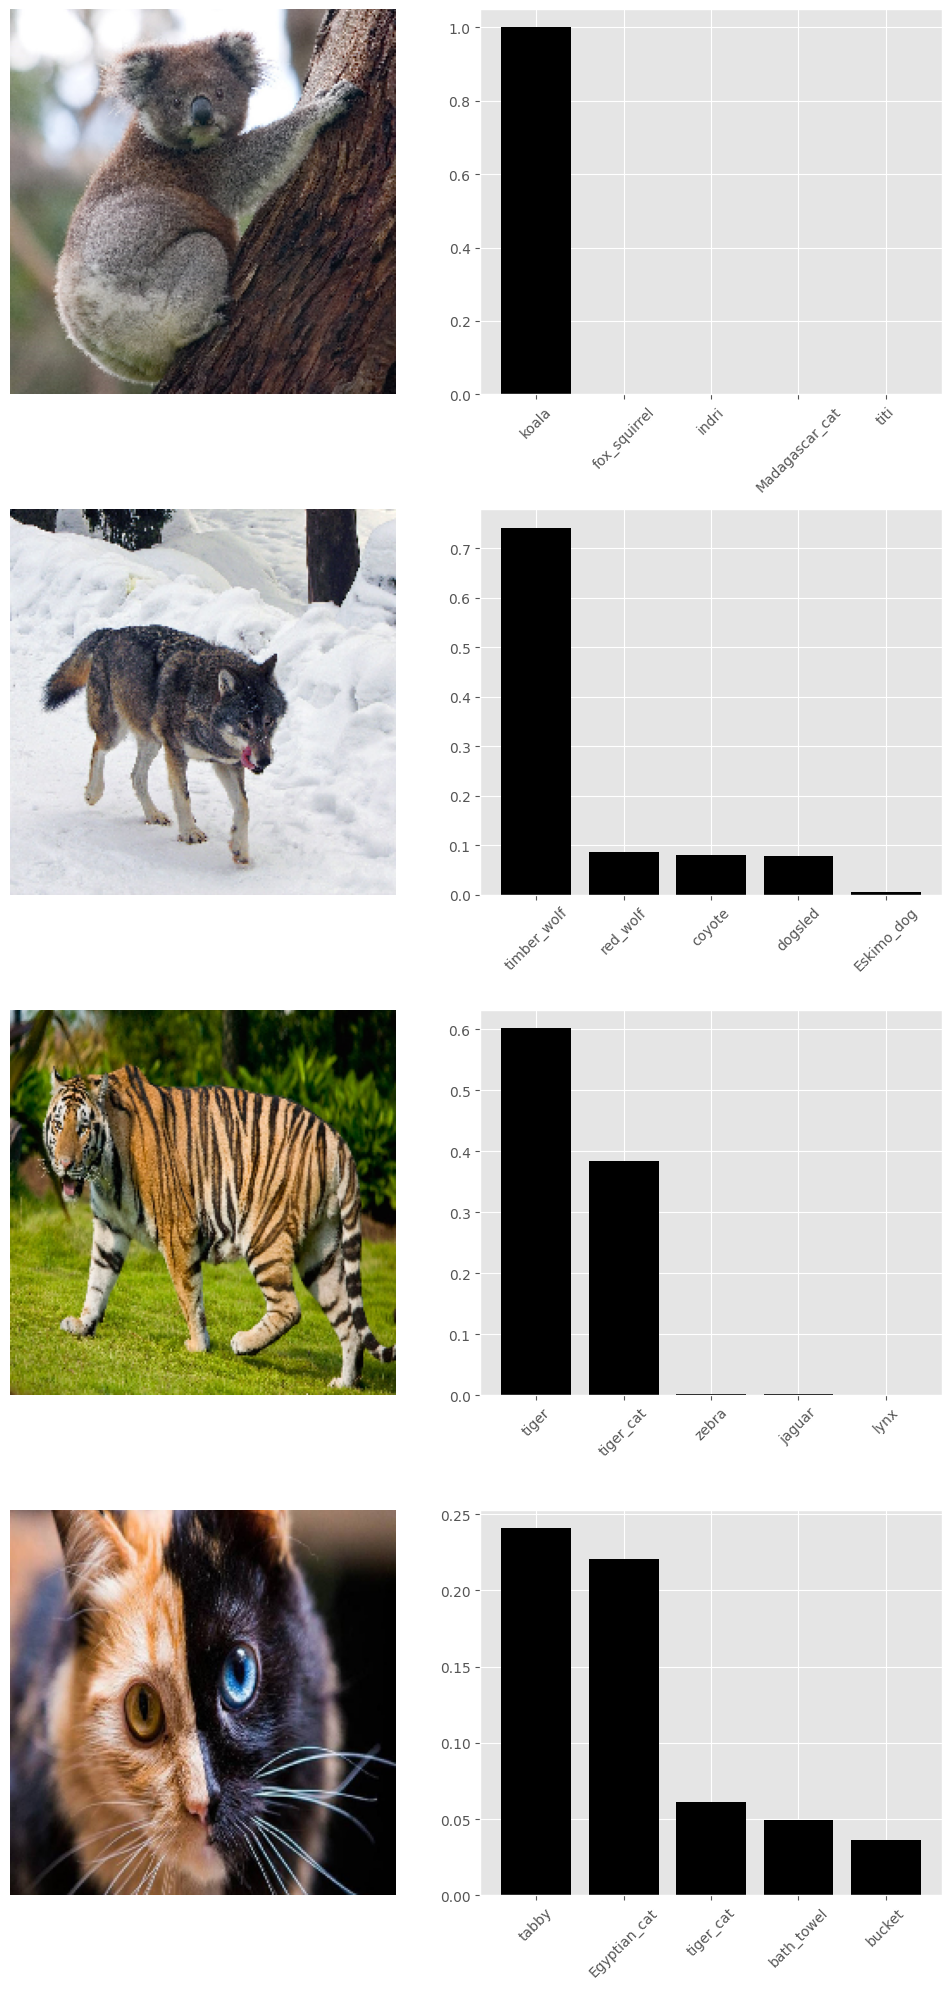

In [ ]:
# Obtenemos las predicciones
preds = model.predict(ims_prep)
# Obtenemos el nombre de las categorías predichas
labs = tf.keras.applications.inception_v3.decode_predictions(preds)
# Mostramos las imágenes y las categorías predichas
fig, ax = plt.subplots(4, 2, figsize=(10,20))
for i in range(4):
    ax[i, 0].imshow(ims[i]); ax[i, 0].axis("off")
    ax[i, 1].bar(list(map(lambda x:x[1], labs[i])),
                 list(map(lambda x:x[2], labs[i])), color="k")
    ax[i,1].set_xticklabels(list(map(lambda x:x[1], labs[i])), rotation=45)
fig.tight_layout()

Para poder utilizar estas redes en un problema nuevo, podemos seguir dos metodologías dependiendo del tamaño del dataset y de la afinidad del problema con el conjunto de datos en el que se hizo el entrenamiento originalmente :

<center><img src = "https://drive.google.com/uc?export=view&id=14MQ8XtP6ZgA2lwDcbn4JOWcpXxsqz2uo" alt = "Diagrama ilustrativo de las metodologías de Transfer Learning y Fine Tuning" width = "70%">  </img></center>



Veamos en detalle cómo realizar *Transfer Learning* y *Fine Tuning*:

# **2. _Transfer Learning_**
----

Los seres humanos tenemos una habilidad inherente de transferir conocimiento entre distintas tareas, es decir, lo que aprendemos en determinada tarea lo podemos reutilizar para resolver tareas relacionadas. Entre más similares sean las tareas, más fácil es el aprendizaje. Veamos algunos ejemplos sencillos:

* Saber cómo montar bicicleta $\rightarrow$ Aprender a conducir una moto.
* Saber cómo tocar música clásica en piano $\rightarrow$ Aprender a tocar jazz en piano.
* Tener conocimiento en matemática, programación y estadística $\rightarrow$ Aprender *machine learning*.

Esta es la base de **_Transfer Learning_**, donde se busca que las redes neuronales aprendan una nueva tarea partiendo de un conocimiento base :


<center><img src = "https://drive.google.com/uc?export=view&id=1kUMODR1rk1i1C9RCj85mGZAI8TKk12Ij" alt = "Diagrama ilustrativo de la aplicación de Transfer Learning a un conjunto de datos de imágenes médicas" width = "80%">  </img></center>

Como mencionamos anteriormente, esta técnica se utiliza comúnmente cuando tenemos datasets pequeños. La idea es utilizar una representación intermedia de una red profunda para obtener una representación de los datos de entrada.

Por ejemplo, en el caso de **las imágenes**, un enfoque típico es utilizar las capas convolucionales como extractores de características para posteriormente entrenar una red neuronal multicapa en la nueva tarea.


## **2.1. Definición del modelo**
----

Veamos un ejemplo práctico de esto con _TensorFlow_, para ello, utilizaremos una [*EfficientNetB0*](https://arxiv.org/abs/1905.11946). Este modelo lo introdujo Google AI, con la intención de proponer un método eficiente, como sugiere su nombre, al tiempo que mejora los resultados del estado del arte. Generalmente para mejorar en las métricas de clasificación, los modelos se hacen demasiado anchos, profundos o con una resolución muy alta. Aumentar estas características ayuda al modelo inicialmente pero rápidamente se satura y el modelo final sólo tiene más parámetros y por lo tanto no es eficiente. En _EfficientNet_ se escalan de un modo más basado en principios, es decir, se aumenta todo gradualmente.


Veamos un ejemplo con el dataset de clasificación de rostros, comenzamos cargando un extractor de características, es decir no vamos a incluir la parte superior del modelo donde se hace la clasificación (`include_top=False`):

In [ ]:
# Cargamos EfficientNet sin el top (capas densas del final)
extractor = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                            include_top=False,
                                            input_shape=(224, 224, 3))
extractor.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescal

Ahora, agregamos un nuevo clasificador (con pesos aleatorios) para transferir el conocimiento de ImageNet al problema con dataset de caras reales y falsas:

**Congelar Capas**

Primero vamos a _congelar_ las capas que pertenecen al modelo original de _EfficientNet_, esto es, definir que los pesos de esas capas no se van a entrenar. Cada capa `layer` del modelo `extractor` tiene un atributo booleano (`True` o `False`) llamado `trainable`. Vamos a definirlo `False` en todas las `layers` de `extractor`:

In [ ]:
# Congelamos el extractor de características (Transfer Learning)
for layer in extractor.layers:
    layer.trainable=False

**Agregar un Clasificador**

Ahora agregamos a el modelo las capas que constituyen el clasificador final, un simple perceptrón multicapa que va a actuar sobre la salida del modelo `extractor`:


In [ ]:
# Creamos una capa de pooling para consolidar los feature maps de salida en
# 1024 valores
pool = tf.keras.layers.GlobalAveragePooling2D()(extractor.output)
# Agregamos una capa densa
dense1 = tf.keras.layers.Dense(units=32, activation="relu")(pool)
# Agregamos dropout para regularización
drop1 = tf.keras.layers.Dropout(0.2)(dense1)
# Agregamos una capa de salida
dense2 = tf.keras.layers.Dense(units=2, activation="softmax")(drop1)
# Definimos nuestro modelo de transfer learning
tl_model = tf.keras.models.Model(inputs=[extractor.input], outputs=[dense2])
# Compilamos el modelo
tl_model.compile(loss="categorical_crossentropy",
                 optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                 metrics=["accuracy"])
tl_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

Las últimas cuatro capas del modelo anterior constituyen entonces el clasificador:

```
global_average_pooling2d (Glob  (None, 1280)        0           ['top_activation[0][0]']         
 alAveragePooling2D)                                                                              
                                                                                                  
 dense (Dense)                  (None, 32)           40992       ['global_average_pooling2d[0][0]'
                                                                 ]                                
                                                                                                  
 dropout (Dropout)              (None, 32)           0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 2)            66          ['dropout[0][0]']                
                                                                                                  
==================================================================================================
Total params: 4,090,629
Trainable params: 4,048,606
Non-trainable params: 42,023
```

La salida de `global_average_pooling2d` constituyen las características extraídas de la imagen que entra al modelo completo. Es decir, el extractor de características transforma cada imagen en un vector de tamaño 1280. Este vector entra entonces a un modelo de dos capas densas: una capa oculta de 32 neuronas con _dropout_, y la capa de salida de dos neuronas. Estas capas aportan los 41058 parámetros que se van a entrenar. Note que los parámetros del modelo base no cuentan como parámetros entrenables.

## **2.2. Data augmentation y preprocesamiento**
----

Para entrenar el modelo utilizaremos _Data Augmentation_, de la misma forma como lo utilizamos en el notebook anterior (_Introducción a las Redes Neuronales Convolucionales (CNN)_):

In [ ]:
# Definimos las transformaciones para data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                fill_mode='constant')

Utilizamos el preprocesamiento de la _EfficientNet_ para transformar los conjuntos:

In [ ]:
X_train_prep = tf.keras.applications.efficientnet.preprocess_input(X_train)
X_val_prep = tf.keras.applications.efficientnet.preprocess_input(X_val)

Ahora, definimos el generador de entrenamiento. El conjunto de validación y de prueba se dejarán intactos, para poder evaluar sobre datos reales, y como son pequeños y caben en memoria, no ameritan un generador.

In [ ]:
train_gen = train_datagen.flow(x=X_train_prep,
                               y=Y_train,
                               batch_size=32)

## **2.3. Entrenamiento**
----

Para el entrenamiento, utilizaremos un _Callback_ para guardar el modelo con menor pérdida en validación; guardaremos los pesos del mejor modelo en un archivo llamado: `transfer_learning.h5`.

> **Nota**:  `transfer_learning.h5` se guardará temporalmente solo mientras el entorno de ejecución está conectado.

In [ ]:
# Definimos el callback
best_callback = tf.keras.callbacks.ModelCheckpoint(filepath="transfer_learning.h5",
                                                   monitor="val_loss",
                                                   verbose=True,
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   mode="min")
# Entrenamos el modelo
hist_tl = tl_model.fit(x=train_gen,
                       validation_data=(X_val_prep, Y_val),
                       epochs=10,
                       steps_per_epoch=X_train.shape[0]//32,
                       callbacks=[best_callback])

Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 0.7077 - accuracy: 0.5408
Epoch 1: val_loss improved from inf to 0.68273, saving model to transfer_learning.h5
44/44 [==============================] - 27s 431ms/step - loss: 0.7077 - accuracy: 0.5408 - val_loss: 0.6827 - val_accuracy: 0.5661
Epoch 2/10
44/44 [==============================] - ETA: 0s - loss: 0.6577 - accuracy: 0.6010
Epoch 2: val_loss did not improve from 0.68273
44/44 [==============================] - 16s 360ms/step - loss: 0.6577 - accuracy: 0.6010 - val_loss: 0.6865 - val_accuracy: 0.5661
Epoch 3/10
44/44 [==============================] - ETA: 0s - loss: 0.6386 - accuracy: 0.6311
Epoch 3: val_loss did not improve from 0.68273
44/44 [==============================] - 15s 349ms/step - loss: 0.6386 - accuracy: 0.6311 - val_loss: 0.6867 - val_accuracy: 0.5579
Epoch 4/10
44/44 [==============================] - ETA: 0s - loss: 0.6185 - accuracy: 0.6676
Epoch 4: val_loss did not improve from 0.68273
44

## **2.4. Evaluación**
----

Ahora, evaluaremos el desempeño del modelo en términos de _accuracy_, _recall_, _precision_ y _F1 Score_. Primero cargamos los pesos del mejor modelo usando la función `load_weights`, que recibe directamente el archivo en formato `h5`:

In [ ]:
# Cargamos el mejor modelo
tl_model.load_weights("transfer_learning.h5")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, np.argmax(tl_model.predict(X_val_prep,
                                                              batch_size=32),
                                            axis=1)
                            ))

20/20 [==============================] - 2s 55ms/step
              precision    recall  f1-score   support

           0       0.52      0.67      0.59       284
           1       0.63      0.47      0.54       329

    accuracy                           0.57       613
   macro avg       0.58      0.57      0.56       613
weighted avg       0.58      0.57      0.56       613



# **3. _Fine Tuning_**
----

Cuando el dataset nuevo no es tan parecido al problema original (por ejemplo, cuando se quiere hacer análisis de imágenes médicas), no es muy recomendable utilizar características de tan alto nivel. En este caso, se aplica **_fine tuning_** para poder entrenar otras capas del modelo base y ajustar la red mejor a nuestro problema en partícular :
<center><img src = "https://drive.google.com/uc?export=view&id=1XNazt6CfzxCIAElz0KJotnYh9M8U4ory" alt = "Diagrama ilustrativo de la aplicación de Fine Tuning a un conjunto de datos de imágenes de frotis sanguíneo" width = "70%">  </img></center>

*Fine Tuning* permite de **aprender mejores parámetros a cambio de un mayor tiempo de entrenamiento**. Así mismo, se trata de un método que requiere una buena experimentación para poder converger. A continuación, se presentan algunos consejos que se pueden aplicar para mejorar el *Fine Tuning*:

* **Calentamiento**: Al igual que en *Transfer Learning*, las últimas capas densas son reemplazadas por un nuevo clasificador, no obstante, al iniciar con pesos completamente aleatorios se pueden dañar las representaciones de las capas de bajo nivel. Por ello, es recomendable entrenar primero un poco (calentamiento) las capas del final antes de entrenar todo el modelo.

* **Taza de aprendizaje**: Lo recomendable para *Fine Tuning* es utilizar valores pequeños de _learning rate_ (o tasa de aprendizaje), al menos, valores menores de los que se usan en *Transfer Learning*.

* **Congelamiento**: En muchos casos no es tan recomendable entrenar toda la red, por ejemplo, en redes convolucionales los filtros de las primeras capas convergen a valores similares (tienden a ser filtros de bordes o de forma), por ello, es necesario explorar a qué porcentaje de capas se les realizará *Fine Tuning*.

Veamos un ejemplo de *Fine Tuning*:


## **3.1. Definición del modelo**
----

En este caso utilizaremos la misma arquitectura que usamos en *Transfer Learning*, no obstante, más adelante también entrenaremos las capas convolucionales de la _EfficientNet_:

In [ ]:
# Cargamos EfficientNet sin el top (capas densas del final)
extractor = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                            include_top=False,
                                            input_shape=(224, 224, 3))

# Congelamos el extractor de características
for layer in extractor.layers:
    layer.trainable=False

# Creamos una capa de pooling para eliminar los ejes no deseados
pool = tf.keras.layers.GlobalAveragePooling2D()(extractor.output)
# Agregamos una capa densa
dense1 = tf.keras.layers.Dense(units=32, activation="relu")(pool)
# Agregamos dropout para regularización
drop1 = tf.keras.layers.Dropout(0.2)(dense1)
# Agregamos una capa de salida
dense2 = tf.keras.layers.Dense(units=2, activation="softmax")(drop1)
# Definimos nuestro modelo de transfer learning
ft_model = tf.keras.models.Model(inputs=[extractor.input], outputs=[dense2])
ft_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

## **3.2. Calentamiento (*Warming Up*)**
----
Comenzamos entrenando sólo un poco (en este caso máximo 10 _epochs_) las nuevas capas densas del final fijando el learning rate en $10^{-3}$.Guardamos el mejor modelo para luego empezar desde ese punto el entrenamiento de _Fine Tuning_.


In [ ]:
# Compilamos el modelo
ft_model.compile(loss="categorical_crossentropy",
                 optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                 metrics=["accuracy"])

# Definimos el callback
best_callback = tf.keras.callbacks.ModelCheckpoint(filepath="warming_up.h5",
                                                   monitor="val_loss",
                                                   verbose=True,
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   mode="min")

# Entrenamos el modelo
ft_model.fit_generator(train_gen,
                       validation_data=(X_val_prep, Y_val),
                       epochs=10,
                       steps_per_epoch=X_train.shape[0]//32,
                       callbacks=[best_callback])

<ipython-input-23-b9a6963a7ba1>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  ft_model.fit_generator(train_gen,


Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 0.7133 - accuracy: 0.5408
Epoch 1: val_loss improved from inf to 0.68006, saving model to warming_up.h5
44/44 [==============================] - 35s 400ms/step - loss: 0.7133 - accuracy: 0.5408 - val_loss: 0.6801 - val_accuracy: 0.5710
Epoch 2/10
44/44 [==============================] - ETA: 0s - loss: 0.6447 - accuracy: 0.6246
Epoch 2: val_loss did not improve from 0.68006
44/44 [==============================] - 16s 353ms/step - loss: 0.6447 - accuracy: 0.6246 - val_loss: 0.6826 - val_accuracy: 0.5971
Epoch 3/10
44/44 [==============================] - ETA: 0s - loss: 0.6367 - accuracy: 0.6483
Epoch 3: val_loss did not improve from 0.68006
44/44 [==============================] - 16s 366ms/step - loss: 0.6367 - accuracy: 0.6483 - val_loss: 0.7026 - val_accuracy: 0.5824
Epoch 4/10
44/44 [==============================] - ETA: 0s - loss: 0.6209 - accuracy: 0.6354
Epoch 4: val_loss improved from 0.68006 to 0.66624, savi

## **3.3. Ajuste Fino (_Fine Tuning_)**
----

Ahora disminuimos el learning rate y permitimos entrenar todas las capas de la red. Esto se logra cambiando el atributo `trainable` a `True` de cada una de las capas correspondientes. Cargamos los pesos obtenidos durante el calentamiento y bajamos la tasa de aprendizaje a $10^{-4}$. Recordemos que esto lo hacemos porque solo queremos hacer ajustes muy ligeros a los pesos del modelo.


In [ ]:
# Hacemos entrenables todas las capas
for layer in ft_model.layers:
    layer.trainable = True

# Disminuímos el learning rate
ft_model.compile(loss="categorical_crossentropy",
                 optimizer=tf.optimizers.Adam(learning_rate=1e-4),
                 metrics=["accuracy"])

# Cargamos los pesos del calentamiento
ft_model.load_weights("warming_up.h5")

# Definimos el callback
best_callback = tf.keras.callbacks.ModelCheckpoint(filepath="fine_tuning.h5",
                                                   monitor="val_loss",
                                                   verbose=True,
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   mode="min")

In [ ]:
# Entrenamos
hist_ft = ft_model.fit(train_gen,
                        validation_data=(X_val_prep, Y_val),
                        epochs=20,
                        steps_per_epoch=X_train.shape[0]//32,
                        callbacks=[best_callback])

Epoch 1/20
44/44 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 0.5867
Epoch 1: val_loss improved from inf to 0.68522, saving model to fine_tuning.h5
44/44 [==============================] - 70s 463ms/step - loss: 0.6835 - accuracy: 0.5867 - val_loss: 0.6852 - val_accuracy: 0.5808
Epoch 2/20
44/44 [==============================] - ETA: 0s - loss: 0.5769 - accuracy: 0.7013
Epoch 2: val_loss improved from 0.68522 to 0.65162, saving model to fine_tuning.h5
44/44 [==============================] - 20s 446ms/step - loss: 0.5769 - accuracy: 0.7013 - val_loss: 0.6516 - val_accuracy: 0.6166
Epoch 3/20
44/44 [==============================] - ETA: 0s - loss: 0.5369 - accuracy: 0.7393
Epoch 3: val_loss improved from 0.65162 to 0.63207, saving model to fine_tuning.h5
44/44 [==============================] - 20s 447ms/step - loss: 0.5369 - accuracy: 0.7393 - val_loss: 0.6321 - val_accuracy: 0.6378
Epoch 4/20
44/44 [==============================] - ETA: 0s - loss: 0.4488 - 

## **3.4. Evaluación**
----

Ahora evaluaremos el modelo en términos de _accuracy, recall, precision_ y f1:

In [ ]:
# Cargamos el mejor modelo
ft_model.load_weights("fine_tuning.h5")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, np.argmax(ft_model.predict(X_val_prep,
                                                              batch_size=32),
                                              axis=1)
                            ))

20/20 [==============================] - 2s 54ms/step
              precision    recall  f1-score   support

           0       0.60      0.63      0.62       284
           1       0.67      0.64      0.66       329

    accuracy                           0.64       613
   macro avg       0.64      0.64      0.64       613
weighted avg       0.64      0.64      0.64       613



Por último, compararemos las pérdidas y el accuracy de los dos modelos a lo largo de las iteraciones:

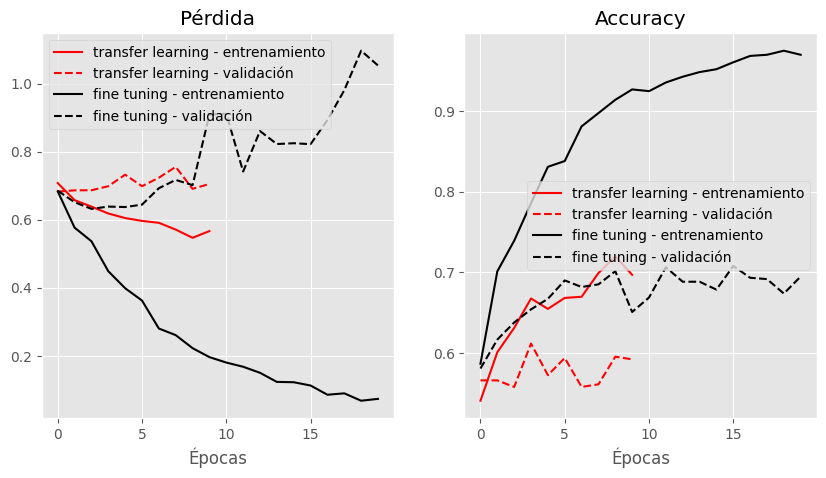

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(hist_tl.history["loss"], "r", label="transfer learning - entrenamiento")
plt.plot(hist_tl.history["val_loss"], "r--", label="transfer learning - validación")
plt.plot(hist_ft.history["loss"], "k", label="fine tuning - entrenamiento")
plt.plot(hist_ft.history["val_loss"], "k--", label="fine tuning - validación")
plt.xlabel("Épocas")
plt.title("Pérdida")
plt.legend()
plt.subplot(122)
plt.plot(hist_tl.history["accuracy"], "r", label="transfer learning - entrenamiento")
plt.plot(hist_tl.history["val_accuracy"], "r--", label="transfer learning - validación")
plt.plot(hist_ft.history["accuracy"], "k", label="fine tuning - entrenamiento")
plt.plot(hist_ft.history["val_accuracy"], "k--", label="fine tuning - validación")
plt.xlabel("Épocas")
plt.title("Accuracy")
plt.legend()

Compare los resultados obtenidos entre _Transfer Learning_ y _Fine Tuning_. Los últimos son mejores. Sin embargo, aunque parezca fácil, estas técnicas no siempre van a funcionar con cualquier modelo en cualquier conjunto de datos. Todo hay que explorarlo y tener mucha paciencia en el proceso.

# **Recursos adicionales**
----

* [*Transfer Learning Introduction*](https://www.hackerearth.com/practice/machine-learning/transfer-learning/transfer-learning-intro/tutorial/)
* A. G. Howard et al., “MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications.”
* [*Fine-tuning guidelines*](https://image.slidesharecdn.com/stcbwed1730mac205-161230131625/95/aws-reinvent-2016-deep-learning-at-cloud-scale-improving-video-discoverability-by-scaling-up-caffe-on-aws-mac205-28-638.jpg?cb=1483103838)
* [*Transfer learning: the dos and don’ts*](https://medium.com/starschema-blog/transfer-learning-the-dos-and-donts-165729d66625)
* [*Transfer Learning : Approaches and Empirical Observations*](https://hackernoon.com/transfer-learning-approaches-and-empirical-observations-efeff9dfeca6)
* [*A Comprehensive Hands-on Guide to Transfer Learning with Real-World Applications in Deep Learning*](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)


* _Origen de los íconos_

    - Alex Krizhevsky. The CIFAR-10 dataset [JPG]. https://www.cs.toronto.edu/~kriz/cifar.html
    - Flaticon. Free Check Icon [PNG]. https://www.flaticon.com/free-icon//cheque_3699516
    - Flaticon. Free Cross Icon [PNG]. https://www.flaticon.com/free-icon//cruzar_6711656
    - Flaticon. Free New Car Icon [PNG]. https://www.flaticon.com/free-icon//carro-nuevo_5044540
    - Flaticon. Free Cart Icon [PNG]. https://www.flaticon.com/free-icon//carro_1574481
    - MDPI. Ball chart reporting the Top-1 ImageNet-1k accuracy vs. computational complexity
 [JPG]. https://www.mdpi.com/electronics/electronics-11-00945/article_deploy/html/images/electronics-11-00945-g001-550.jpg



    

    
    

# **Créditos**
---

* **Profesor:** [Fabio Augusto Gonzalez](https://dis.unal.edu.co/~fgonza/)
* **Asistentes docentes :**
  * [Santiago Toledo Cortés](https://sites.google.com/unal.edu.co/santiagotoledo-cortes/)
* **Diseño de imágenes:**
    - [Mario Andres Rodriguez Triana](https://www.linkedin.com/in/mario-andres-rodriguez-triana-394806145/).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*